## TimesNet (2023)

In [ ]:
# TimesNet은 시계열 데이터를 2D 텐서로 변환하여 intra-period와 inter-period 변동성을 효과적으로 모델링하는 최신 딥러닝 아키텍처

## 1. TimesNet을 활용한 삼성전자 주가 예측 예제

### 1-1 데이터 수집 및 전처리

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np

# 삼성전자 주가 데이터 수집
df = stock.get_market_ohlcv_by_date("2023-01-01", "2025-06-25", "005930")
df = df[['종가']].rename(columns={'종가': 'Close'})

# 수익률 계산
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# 시계열 윈도우 생성
input_size = 10
X, y = [], []
returns = df['Return'].values
for i in range(len(returns) - input_size):
    X.append(returns[i:i + input_size])
    y.append(returns[i + input_size])

X = np.array(X)
y = np.array(y)


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1-2  TimesNet 모델 정의 및 학습

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# TimesNet 모델 정의
class TimesNet(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2):
        super(TimesNet, self).__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, d_model)
        x = self.transformer(x)
        out = x[-1]  # 마지막 시점만 예측
        return self.fc(out)

# 데이터 텐서 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 학습/테스트 분리
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# 모델 초기화 및 학습
model = TimesNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/100, Loss: 0.133856
Epoch 20/100, Loss: 0.005506
Epoch 30/100, Loss: 0.006888
Epoch 40/100, Loss: 0.006453
Epoch 50/100, Loss: 0.004633
Epoch 60/100, Loss: 0.004272
Epoch 70/100, Loss: 0.003187
Epoch 80/100, Loss: 0.003300
Epoch 90/100, Loss: 0.003073
Epoch 100/100, Loss: 0.003503


### 1-3 예측 및 평가

MAE: 0.017440
R²: -0.4437


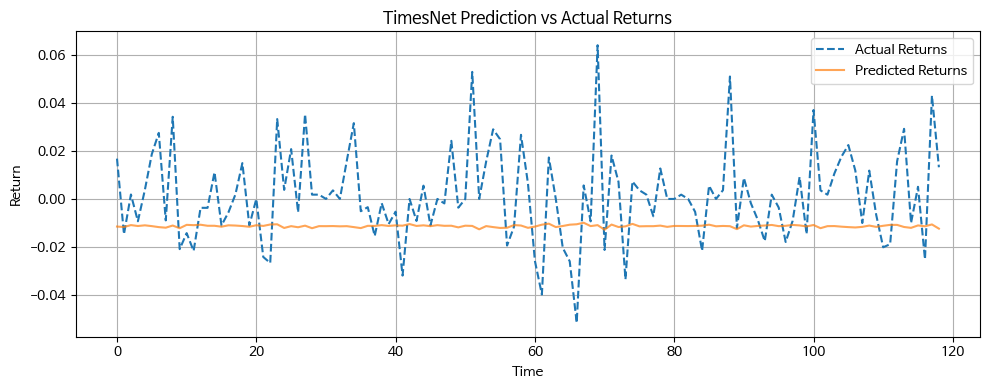

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

# 성능 지표 계산
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.4f}")

# 예측 결과 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Actual Returns", linestyle='--')
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.title("TimesNet Prediction vs Actual Returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. 다중 자산 시계열 예측(Multi-Asset Time Series Forecasting)

In [ ]:
# 입력: 최근 10일간 3개 종목(삼성전자, SK하이닉스, 현대차)의 수익률
# 출력: 삼성전자의 다음날 수익률 예측

In [ ]:
# 항목	내용
# 입력	10일 × 3종목 수익률 (시계열+자산차원)
# 출력	다음날 삼성전자 수익률
# 네트워크	Linear 임베딩 → Transformer Encoder → FC
# 목적	여러 자산의 상관관계를 반영하여 단일 종목 예측 정확도 향상

C:\Users\JYB\AppData\Local\Temp\ipykernel_21548\557581686.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)  # (samples, 10, 3)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10: Loss = 0.028239
Epoch 20: Loss = 0.038551
Epoch 30: Loss = 0.010487
Epoch 40: Loss = 0.008597
Epoch 50: Loss = 0.008786
Epoch 60: Loss = 0.007865
Epoch 70: Loss = 0.007800
Epoch 80: Loss = 0.006549
Epoch 90: Loss = 0.006870
Epoch 100: Loss = 0.006534

✅ MAE: 0.017704, R²: -0.3007


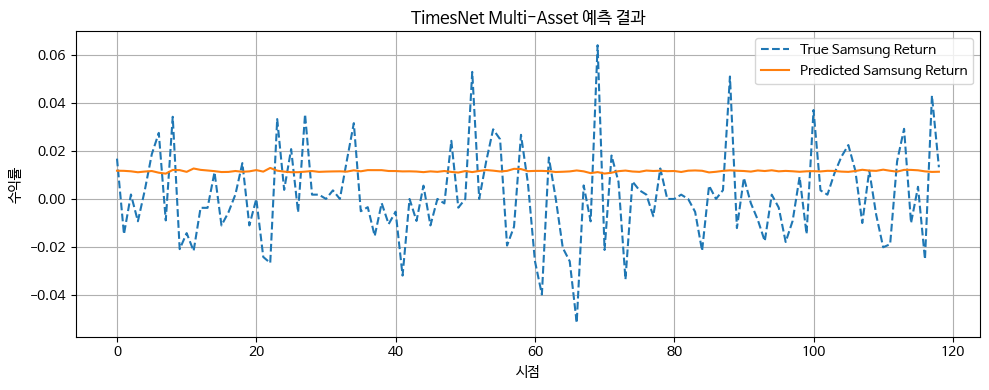

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from pykrx import stock
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ▒ 데이터 로딩 및 수익률 계산 ▒
tickers = {'삼성전자': '005930', 'SK하이닉스': '000660', '현대차': '005380'}
df_all = pd.DataFrame()

for name, code in tickers.items():
    df = stock.get_market_ohlcv_by_date("2023-01-01", "2025-06-25", code)
    df = df[['종가']].rename(columns={'종가': name})
    df_all = pd.concat([df_all, df], axis=1)

df_all.dropna(inplace=True)
returns = df_all.pct_change().dropna()
returns.columns = ['Samsung', 'Hynix', 'Hyundai']

# ▒ TimesNet 입력 생성: (N, seq_len, features) ▒
seq_len = 10
X, y = [], []

for i in range(len(returns) - seq_len):
    X.append(returns.iloc[i:i+seq_len].values)  # (10, 3)
    y.append(returns.iloc[i+seq_len]['Samsung'])  # 다음날 삼성전자 수익률

X = torch.tensor(X, dtype=torch.float32)  # (samples, 10, 3)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# ▒ 학습/테스트 분리 ▒
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ▒ TimesNet 스타일 Transformer 모델 정의 ▒
class TimesNetMultiAsset(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        out = x[-1]  # 마지막 시점
        return self.fc(out)

# ▒ 모델 학습 ▒
model = TimesNetMultiAsset(input_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.6f}")

# ▒ 예측 및 평가 ▒
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n✅ MAE: {mae:.6f}, R²: {r2:.4f}")

# ▒ 결과 시각화 ▒
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="True Samsung Return", linestyle="--")
plt.plot(y_pred, label="Predicted Samsung Return")
plt.title("TimesNet Multi-Asset 예측 결과")
plt.xlabel("시점")
plt.ylabel("수익률")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
